# Regularized Regression

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preliminary Flow

### Load Data

In [2]:
# load data
admit = pd.read_csv('regression_data.csv')
admit.head()

,gre_score,toefl_score,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp,admit_prob
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


### Split Data

In [3]:
# split train test
from sklearn.model_selection import train_test_split

feature = admit.drop(columns='admit_prob')
target = admit[['admit_prob']]

feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [4]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,gre_score,4.489983
2,toefl_score,3.664298
3,univ_ranking,2.572110
4,motiv_letter_strength,2.785764
5,recommendation_strength,1.977698
6,gpa,4.654540
7,research_exp,1.518065


There are several features with high VIF scores:
1. `gre_score`
2. `gpa`

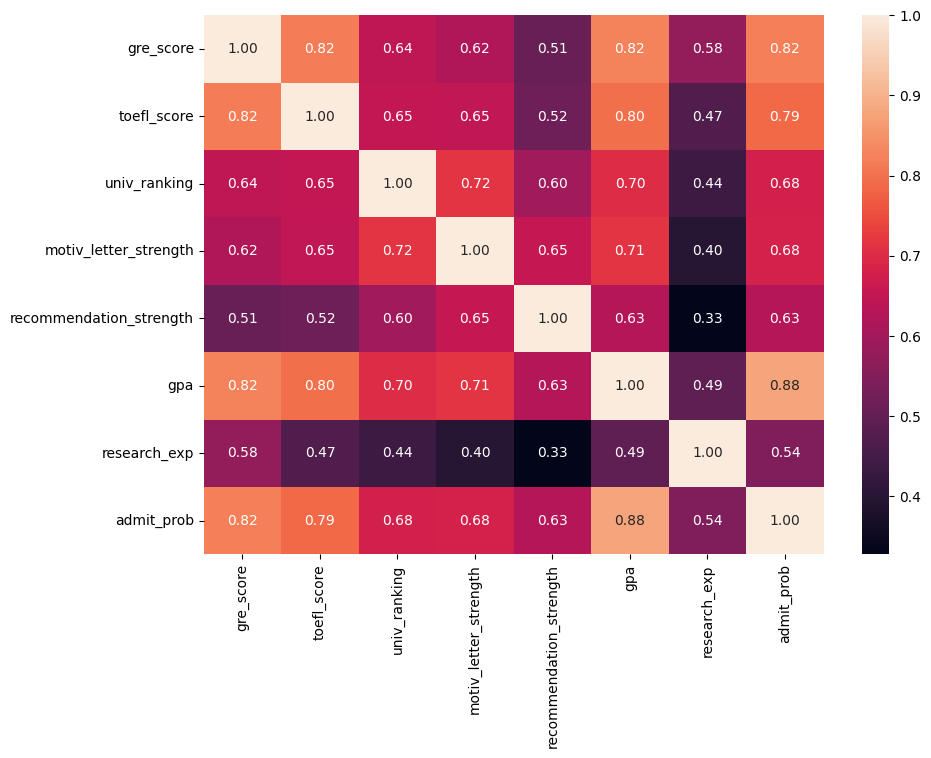

In [5]:
# heatmap correlation
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
corr = admit_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

We choose to retain `gpa`. Therefore, we need to drop:
* `gre_score`
* `toefl_score`

In [6]:
# drop redundant features
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

### Recheck VIF
Optional

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,univ_ranking,2.511407
2,motiv_letter_strength,2.748278
3,recommendation_strength,1.965542
4,gpa,2.726281
5,research_exp,1.350514


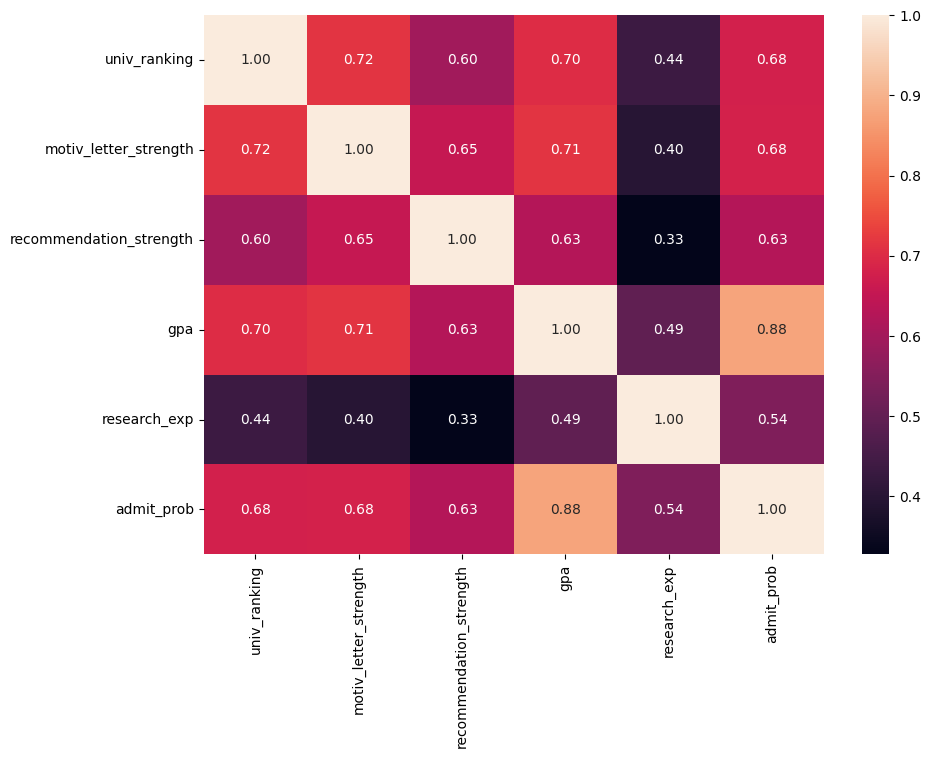

In [8]:
# heatmap correlation
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
corr = admit_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Good!

## Model Training

### Ridge Regression

In [9]:
from sklearn.linear_model import Ridge

# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

# define the model
ridge_reg = Ridge(alpha=0.1, 
                  random_state=42)

ridge_reg.fit(X_admit_train, y_admit_train)

Ridge(alpha=0.1, random_state=42)

In [10]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,-0.764483
1,univ_ranking,0.007031
2,motiv_letter_strength,0.004406
3,recommendation_strength,0.014806
4,gpa,0.160723
5,research_exp,0.038290


## Lasso

In [11]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=0.1, 
                  random_state=42)

lasso_reg.fit(X_admit_train, y_admit_train)

Lasso(alpha=0.1, random_state=42)

In [12]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,0.702539
1,univ_ranking,0.006951
2,motiv_letter_strength,0.000000
3,recommendation_strength,0.000000
4,gpa,0.000000
5,research_exp,0.000000


*Back to slide...*

# Workflow with choosing the best lambda

## Split data: train-validation-test

In [13]:
# split train test
from sklearn.model_selection import train_test_split

feature = admit.drop(columns='admit_prob')
target = admit[['admit_prob']]

# First splitting: pretrain and test
feature_admit_pretrain, feature_admit_test, target_admit_pretrain, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_admit_train, feature_admit_validation, target_admit_train, target_admit_validation = train_test_split(feature_admit_pretrain, target_admit_pretrain, test_size=0.20, random_state=42)

## Drop Multicollinear Features

In [14]:
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_validation = feature_admit_validation.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

## Train Multiple Models
with different alpha (lambda)

In [15]:
from sklearn.linear_model import Ridge

# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

# define the model
# 4 models with 4 different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_admit_train, y_admit_train)
ridge_reg_pointone.fit(X_admit_train, y_admit_train)
ridge_reg_one.fit(X_admit_train, y_admit_train)
ridge_reg_ten.fit(X_admit_train, y_admit_train)

Ridge(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [16]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy()
y_admit_validation = y_admit_validation.reshape(len(y_admit_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 0.057324682661497074
RMSE of Ridge regression model with alpha = 0.1 is 0.057342379647714055
RMSE of Ridge regression model with alpha = 1.0 is 0.05752869822229533
RMSE of Ridge regression model with alpha = 10 is 0.05983184011212863


We can see that Ridge with `alpha=0.01` has the smalles RMSE --> The best model

### Coefficients

In [17]:
ridge_best = ridge_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_admit_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-0.741404
1,univ_ranking,0.005556
2,motiv_letter_strength,0.009497
3,recommendation_strength,0.015778
4,gpa,0.155693
5,research_exp,0.042721


In [30]:
feature_admit_train.columns

Index(['univ_ranking', 'motiv_letter_strength', 'recommendation_strength',
       'gpa', 'research_exp'],
      dtype='object')

# Lasso!
Exercise!

## Train Multiple Models

In [18]:
from sklearn.linear_model import Lasso

# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

# define the model
# 4 models with 4 different alphas (lambda)

# fit the model (training)


## Find the best model (alpha)
Based on validation set

In [19]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy()
y_admit_validation = y_admit_validation.reshape(len(y_admit_validation),)



### Coefficients

In [20]:
# coeffs

### Diagnostic Study
Not mandatory

In [21]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_admit_train)

print('R-squared for training data is {}'.format(r2_score(y_admit_train, y_predict_train)))

R-squared for training data is 0.7983604440801396


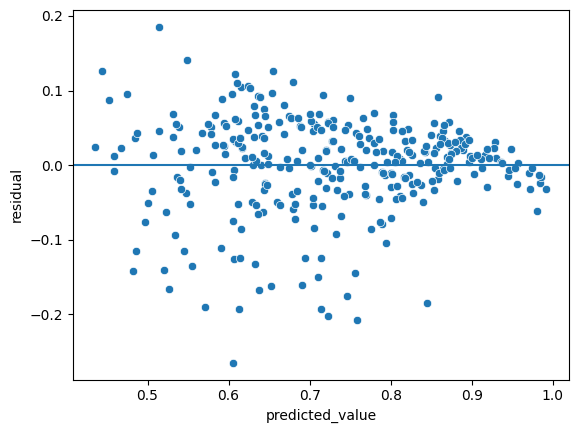

In [22]:
# calculate residuals
residual = y_admit_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Asumsi:
1. Linear relationship: OK. Garis horizontal y=0 cukup merepresentasikan keseluruhan titik residual.
2. Variance stable: NO. Variasinya itu dari lebar (di bagian kiri) ke kecil (di bagian kanan)
3. Independent residual: OK. Tidak ada pattern yang mencolok pada residuals yang berdekatan. 

## Model Evaluation
(Ridge)

### Training Error

In [23]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_admit_train)

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_admit_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 0.06452404616839902
MAE for training data is 0.04696727414428017
MAPE for training data is 0.07615698192361053


### Testing Error

In [25]:
# prepare prediction result on test data
X_admit_test = feature_admit_test.to_numpy()
y_predict_test = ridge_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy()
y_admit_test = y_admit_test.reshape(len(y_admit_test),)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_admit_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_admit_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_admit_test, y_predict_test)))

RMSE for testing data is 0.05897949876358449
MAE for testing data is 0.03966551982284345
MAPE for testing data is 0.06460794974458267


In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_error(y_admit_test, y_predict_test)
mean_absolute_percentage_error(y_admit_test, y_predict_test)

0.06460794974458267

# Predicting Traffic Volume Using Lasso

In [28]:
# load data
traffic = pd.read_csv('/content/drive/MyDrive/Dibimbing/data/traffic_volume.csv')
traffic.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dibimbing/data/traffic_volume.csv'

In [ ]:
# split train test
from sklearn.model_selection import train_test_split

feature = traffic.drop(columns='traffic_volume')
target = traffic[['traffic_volume']]

feature_traffic_pretrain, feature_traffic_test, target_traffic_pretrain, target_traffic_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_traffic_train, feature_traffic_validation, target_traffic_train, target_traffic_validation = train_test_split(feature_traffic_pretrain, target_traffic_pretrain, test_size=0.20, random_state=42)

In [ ]:
# calulcate vif scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_traffic_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

In [ ]:
# heatmap correlation
traffic_train = pd.concat([feature_traffic_train, target_traffic_train], axis=1)
corr = traffic_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

NO need to drop!

In [ ]:
from sklearn.linear_model import Lasso

# train the model
X_traffic_train = feature_traffic_train.to_numpy()
y_traffic_train = target_traffic_train.to_numpy()
y_traffic_train = y_traffic_train.reshape(len(y_traffic_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_traffic_train, y_traffic_train)
lasso_reg_pointone.fit(X_traffic_train, y_traffic_train)
lasso_reg_one.fit(X_traffic_train, y_traffic_train)
lasso_reg_ten.fit(X_traffic_train, y_traffic_train)

## Find the best model (alpha)
Based on validation set

In [ ]:
from sklearn.metrics import mean_squared_error

X_traffic_validation = feature_traffic_validation.to_numpy()
y_traffic_validation = target_traffic_validation.to_numpy()
y_traffic_validation = y_traffic_validation.reshape(len(y_traffic_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_traffic_validation)
    rmse = np.sqrt(mean_squared_error(y_traffic_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

Best lambda/alpha = 10

## Model Evaluation

In [ ]:
lasso_best = lasso_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_traffic_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

### Diagnostic Study

In [ ]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_traffic_train)

print('R-squared for training data is {}'.format(r2_score(y_traffic_train, y_predict_train)))

In [ ]:
# calculate residuals
residual = y_traffic_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

Cek asumsi:
1. Linear relationship: Rather OK. 
2. Variance konstan: NO.
3. Residual independent: NO.

### Training Error

In [ ]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_traffic_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_traffic_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_traffic_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_traffic_train, y_predict_train)))

### Testing Error

In [ ]:
# prepare prediction result on test data
X_traffic_test = feature_traffic_test.to_numpy()
y_predict_test = lasso_best.predict(X_traffic_test)

# ground truth target
y_traffic_test = target_traffic_test.to_numpy()
y_traffic_test = y_traffic_test.reshape(len(y_traffic_test),)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_traffic_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_traffic_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_traffic_test, y_predict_test)))